In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.options import Options

options = Options()
options.headless = True

driver = webdriver.Firefox(options=options)

In [ ]:
driver.get("https://www.wunderground.com/history/monthly/us/ca/burbank/KBUR/date/2000-1")

In [ ]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(driver.page_source)

In [ ]:
soup.find_all(lambda tag:tag.name == "th" and "Max Temperature" == tag.text)[0].find_next_siblings("td")

[<td _ngcontent-app-root-c204="" class="ng-star-inserted">80</td>,
 <td _ngcontent-app-root-c204="" class="ng-star-inserted">66.84</td>,
 <td _ngcontent-app-root-c204="" class="ng-star-inserted">55</td>]

In [ ]:
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

delta = relativedelta(date(2022, 1, 1), date(2000, 1, 1))
dates = [date(2000, 1, 1) + relativedelta(months=month) for month in range(delta.months + (delta.years * 12) + 1)]
dt_strs = list(map(lambda d:d.strftime('%Y-%m'), dates))

In [ ]:
import time
pages = []

for dt_str in dt_strs:
    driver.get(f"https://www.wunderground.com/history/monthly/us/ca/burbank/KBUR/date/{dt_str}")
    time.sleep(5)
    pages.append(BeautifulSoup(driver.page_source))

In [ ]:
feature_names = ["Max Temperature",
                 "Avg Temperature",
                 "Min Temperature",
                 "Dew Point",
                 "Precipitation",
                 "Snowdepth",
                 "Wind",
                 "Gust Wind",
                 "Sea Level Pressure"]
data_frame = {}
for ft in feature_names:
    data_frame[f"{ft} (max)"] = []
    data_frame[f"{ft} (avg)"] = []
    data_frame[f"{ft} (min)"] = []

data_frame["Month"] = pd.Series(dt_strs)

for soup in pages:
    for ft in feature_names:
        try:
            row = soup.find(lambda tag:tag.name == "th" and ft == tag.text)
            mx, avg, mn = map(lambda x:float(x.text), row.find_next_siblings("td")[:3])
        except:
            mx, avg, mn = None, None, None
        data_frame[f"{ft} (max)"].append(mx)
        data_frame[f"{ft} (avg)"].append(avg)
        data_frame[f"{ft} (min)"].append(mn)

In [ ]:
import pandas as pd

pd.DataFrame(data_frame)

,Max Temperature (max),Max Temperature (avg),Max Temperature (min),Avg Temperature (max),Avg Temperature (avg),Avg Temperature (min),Min Temperature (max),Min Temperature (avg),Min Temperature (min),Dew Point (max),...,Wind (max),Wind (avg),Wind (min),Gust Wind (max),Gust Wind (avg),Gust Wind (min),Sea Level Pressure (max),Sea Level Pressure (avg),Sea Level Pressure (min),Month
0,80.0,66.84,55.0,64.96,56.35,47.36,59.0,47.58,36.0,59.0,...,21.0,4.25,0.0,29.0,0.61,0.0,29.51,29.27,29.13,2000-01
1,79.0,63.42,49.0,63.71,55.72,47.22,56.0,48.75,42.0,58.0,...,29.0,5.38,0.0,43.0,1.29,0.0,29.42,29.24,28.93,2000-02
2,83.0,68.16,52.0,69.85,57.36,46.23,54.0,48.35,38.0,54.0,...,32.0,5.67,0.0,44.0,1.66,0.0,29.41,29.14,28.69,2000-03
3,91.0,74.37,57.0,72.54,63.17,53.42,62.0,51.47,0.0,58.0,...,21.0,6.11,0.0,31.0,0.80,0.0,29.31,29.14,29.01,2000-04
4,94.0,78.00,66.0,77.92,67.21,58.12,65.0,58.26,50.0,65.0,...,21.0,6.21,0.0,28.0,0.55,0.0,29.20,29.06,28.93,2000-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,104.0,85.67,67.0,85.25,72.65,63.58,71.0,62.67,56.0,63.0,...,14.0,4.97,0.0,20.0,0.07,0.0,29.27,29.10,28.96,2021-09
261,94.0,77.06,59.0,78.38,65.37,52.29,66.0,54.13,0.0,60.0,...,28.0,4.81,0.0,38.0,1.04,0.0,29.34,28.75,0.00,2021-10
262,93.0,78.16,60.0,79.13,63.65,47.91,66.0,48.81,0.0,55.0,...,40.0,3.52,0.0,54.0,0.75,0.0,29.43,29.23,29.07,2021-11
263,87.0,62.84,48.0,67.39,53.89,47.08,55.0,46.28,38.0,53.0,...,25.0,4.67,0.0,45.0,0.74,0.0,29.41,29.18,28.85,2021-12


In [ ]:
pd.DataFrame(data_frame).isna().any(axis=1).sum()

0

In [ ]:
pd.DataFrame(data_frame).set_index("Month").to_csv("monthly.csv")

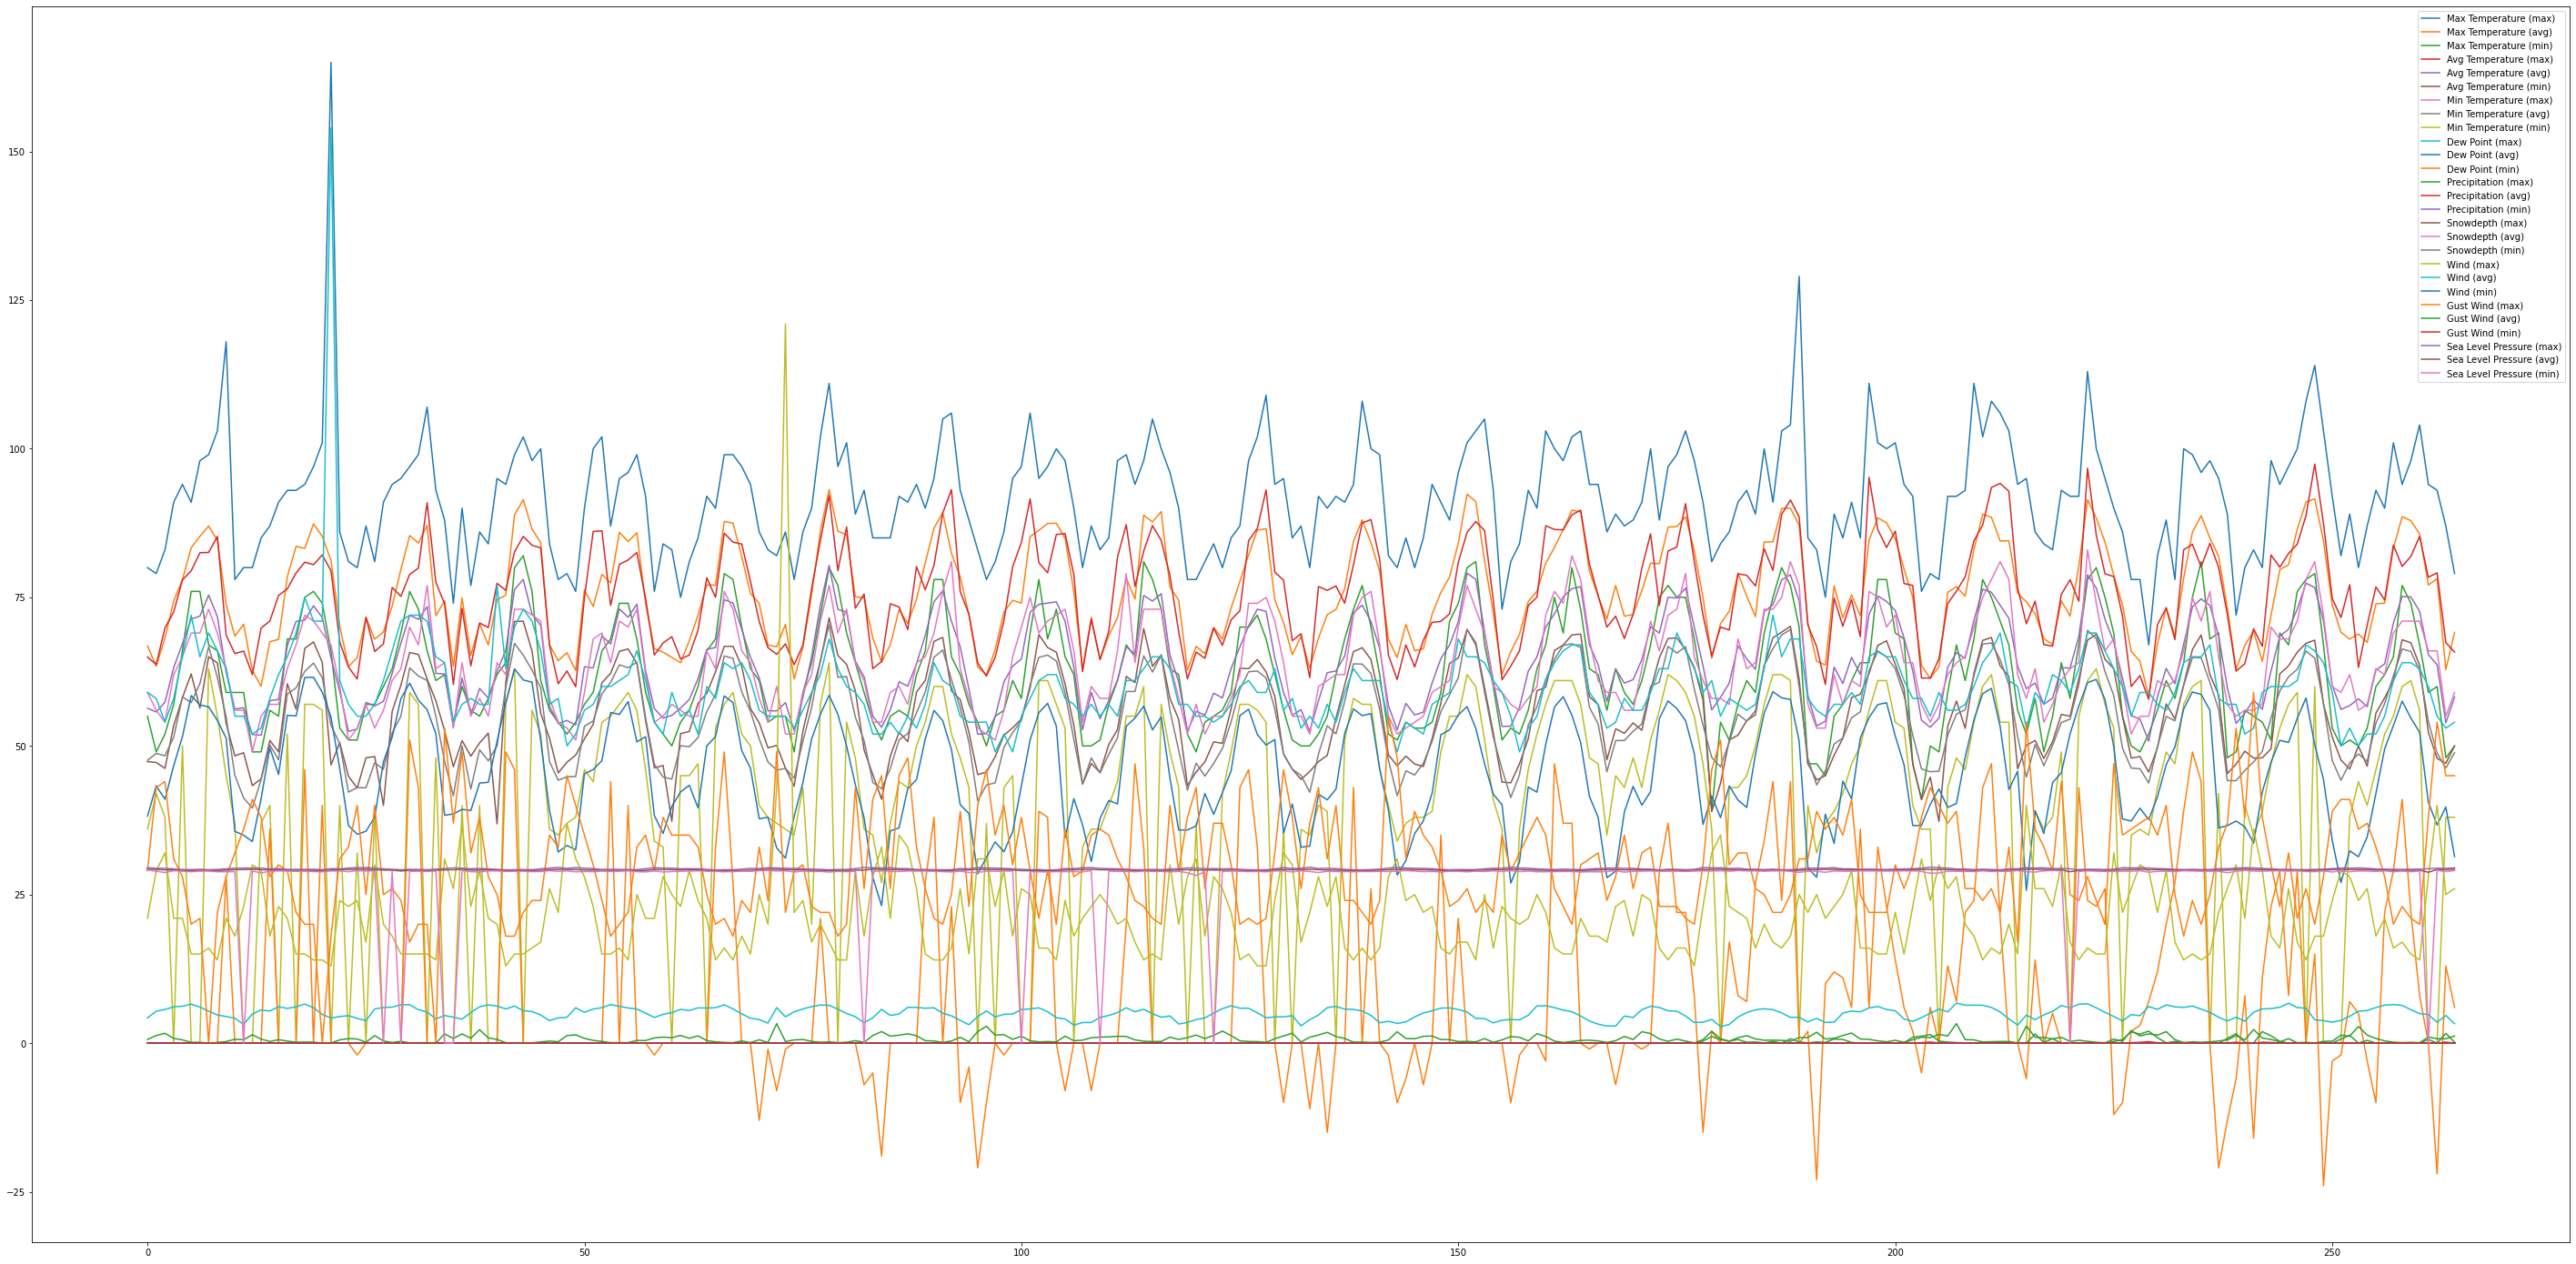

In [ ]:
pd.DataFrame(data_frame).plot(figsize=(50,25)).figure.savefig("monthly.png")